<a href="https://colab.research.google.com/github/OMONa-E/Prediction-of-Product-Sales/blob/main/ML_model_for_product_sales_prediction_(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Model for Prediction of Product Sales (Final)
____
- Author: Omona Emmanuel
____


```
Target: The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales.
```



## Project Overview
#### The main objectives of the project are:

- `Data Loading and Inspection:` The dataset is loaded and inspected to understand its structure and contents. This step involves checking for duplicates, missing values, and inconsistencies in the data.

- `Data Cleaning:` Duplicates are removed, missing values are handled by either filling them with appropriate placeholders or imputing them, and inconsistencies in categorical features are addressed to ensure data quality.

- `Modelling:` Machine Learning(ML) model preparation.

## Load and Inspect Data


In [158]:
# Reading data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# set display to 100 maximum columns
pd.set_option('display.max_columns',100)
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
# Set pandas as the default output for sklearn
set_config(transform_output='pandas')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from google.colab import drive
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor


# define a variable for file path
fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'

# read csv file
df_sales_pred = pd.read_csv(fpath)

# get detail of the dataframe
df_sales_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB




> Our dataframe contain mixture of data types (Number/Object)

> Two features (Item_Weight, Outlet_Size) have missing (null) values





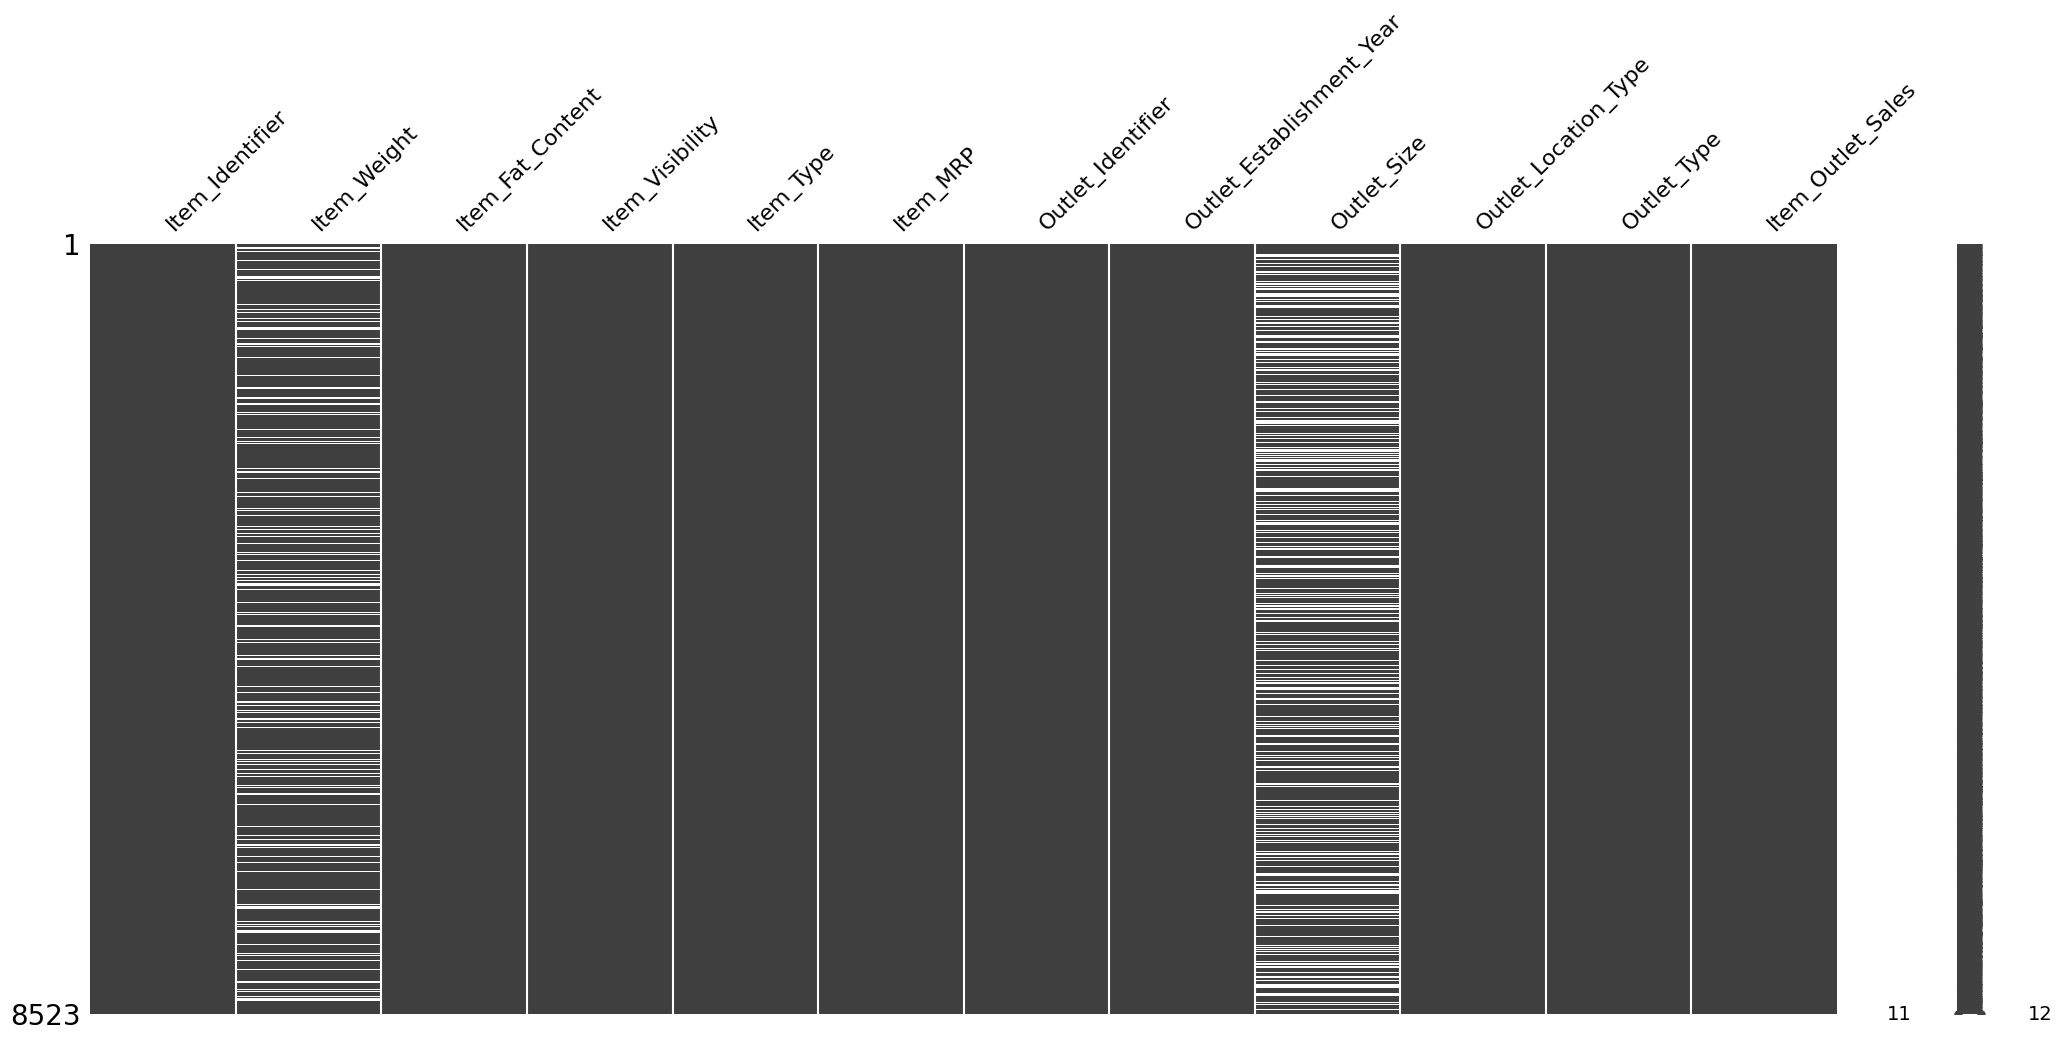

In [160]:
#  Visualing missing data in matrix
msno.matrix(df_sales_pred);

In [161]:
# Describe

# categorical
df_sales_pred.describe(include='object')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577




```
# Item_Identifier series has high cardinality, therefore we shall drop it
# Outlet_Identifier needs dropping - Stakeholder cannot change
# Outlet_Type needs dropping - Stakeholder cannot change
```



In [162]:
# series to be drop
drop_cols = [
    'Item_Identifier',
    'Outlet_Identifier',
    'Outlet_Type',
    'Outlet_Establishment_Year' # Stakeholder cannot change
]

## Clean Data


In [163]:
# Inspecting for duplicates and dropping them
df_sales_pred.duplicated(keep=False).sum()

0

In [164]:
# Quering for records inconsistency
for item in df_sales_pred.select_dtypes('object').columns:
  print(f'{item} column')
  print(f"{df_sales_pred[item].value_counts()}")
  print('\n')

Item_Identifier column
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64


Item_Fat_Content column
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


Item_Type column
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


Outlet_Identifier column
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT0

In [165]:
# Working on inconsistency column @Item_Fat_Content
df_sales_pred['Item_Fat_Content'].replace({
    "LF" : 'Low Fat',
    "reg" : 'Regular',
    "low fat" : 'Low Fat'
}, inplace=True)

# Visualizing inconsistency
df_sales_pred['Item_Fat_Content'].value_counts(dropna=True)

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

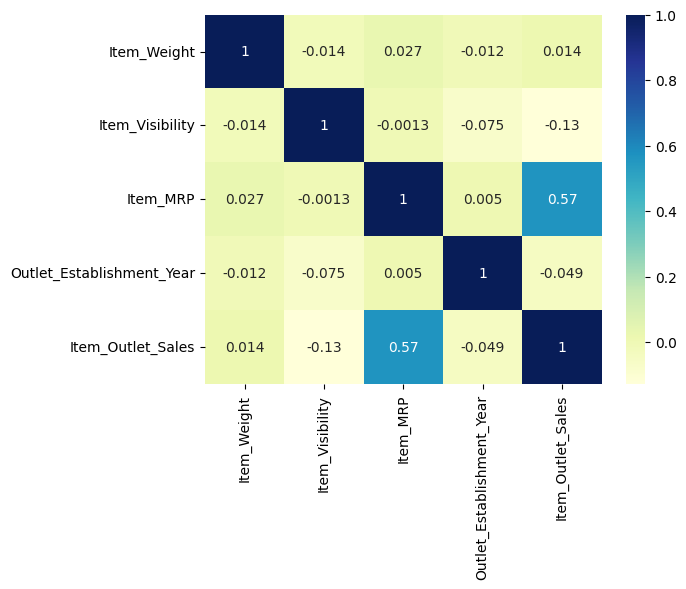

In [166]:
# picking numeric columns with high correlation with Item_Outlet_Sales
num = df_sales_pred.select_dtypes('number').columns
corr = df_sales_pred[num].corr()

sns.heatmap(data=corr, annot=True, cmap='YlGnBu');



> We see only Item_MRP series is highly correlated with ***Item_Outlet_Sales*** - `for this sake we shall use all numerical columns/series/features`



## ML Modelling

## Train Test Split

In [167]:
# define feature matrix, X and target vector, y
y = df_sales_pred['Item_Outlet_Sales']
X = df_sales_pred.drop(columns=[*drop_cols, 'Item_Outlet_Sales'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

display(X_train.head(), X_train.columns)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,Medium,Tier 3
7510,15.250,Regular,0.000000,Snack Foods,179.7660,Medium,Tier 3
5828,12.350,Regular,0.158716,Meat,157.2946,Medium,Tier 1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,Small,Tier 2
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,NaN,Tier 2


Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type'],
      dtype='object')

## Column Transformer

In [168]:
# ordinal column
ord_cols = ['Outlet_Size']

# numeric transformers
num_cols = X_train.select_dtypes('number').columns
impute_median = SimpleImputer(strategy='median')
num_scaler = StandardScaler()
num_pipe = make_pipeline(impute_median, num_scaler)

num_tuple = ('numeric', num_pipe, num_cols)

# categorical transformers
cat_cols = X_train.select_dtypes('object').drop(ord_cols, axis=1).columns
impute_nan = SimpleImputer(strategy='constant', fill_value='nan')
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_pipe = make_pipeline(impute_nan, cat_encoder)

cat_tuple = ('categorical', cat_pipe, cat_cols)

# ordinal transformers
impute_na = SimpleImputer(strategy='constant', fill_value='na')
qual_order = ['na', 'Small', 'Medium', 'High']
ord_col_order = [qual_order]
ord_encoder = OrdinalEncoder(categories=ord_col_order)
ord_scaler = StandardScaler()
ord_pipe = make_pipeline(impute_na, ord_encoder, ord_scaler)

ord_tuple = ('ordinal', ord_pipe, ord_cols)

# Column transformer
column_trans  = ColumnTransformer([num_tuple, cat_tuple, ord_tuple], verbose_feature_names_out=False)

## Linear Regression Model Pipeline

In [169]:
# Linear Regression
lin_reg = LinearRegression()

# model pipeline
model_pipe_lin = make_pipeline(column_trans, lin_reg)

### Fit - Evalaute

In [170]:
# fit
model_pipe_lin.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='nan',
                                                                                 strategy='constant...
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='na',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['na',
                                                                                               'Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

#### Custom Function

In [171]:
# function for regression metrics
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)



### Evaluate

In [172]:
# evaluation
evaluate_regression(model_pipe_lin, X_train, y_train, X_test, y_test, verbose = False, output_frame=True)

,MAE,MSE,RMSE,R^2
Training Data,986.517,1743512.826,1320.421,0.411
Test Data,967.117,1667849.710,1291.453,0.395




> `This model is Underfitting, it's performing poorly on both train and test data sets`



## Random Forest Model Pipeline

In [173]:
# random Forest Regressor
rand_for = RandomForestRegressor(random_state=42)

# model pipeline
model_pipe_rand = make_pipeline(column_trans, rand_for)

### Fit - Evalaute

In [174]:
# fit
model_pipe_rand.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='nan',
                                                                                 strategy='constant...
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='na',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['na',
                                                                                               'Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

### Evaluate

In [175]:
# evaluation
evaluate_regression(model_pipe_rand, X_train, y_train, X_test, y_test, verbose = False, output_frame=True)

,MAE,MSE,RMSE,R^2
Training Data,303.935,193320.339,439.682,0.935
Test Data,786.256,1279446.193,1131.126,0.536




> `This model is Overfitting, it's performing better on train data and poorly on test data`

```
# RandomForestRegressor() performes better than LinearRegression()
```







In [176]:
model_pipe_rand.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='nan',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(ha...
                                                     

## GridSearchCV Tunning

In [181]:
# GridSearchCV parameters for tunning
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4,5,6,7,8,9,10],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

# tune
grid_tune = GridSearchCV(model_pipe_rand, params, n_jobs=-1, verbose=1, cv=3)

# fit
grid_tune.fit(X_train, y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_va...
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [182]:
# best parameter
best_rand_for = grid_tune.best_estimator_

grid_tune.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 10,
 'randomforestregressor__n_estimators': 200,
 'randomforestregressor__oob_score': True}

In [183]:
# Evaluate
evaluate_regression(best_rand_for, X_train, y_train, X_test, y_test, verbose = False, output_frame=True)

,MAE,MSE,RMSE,R^2
Training Data,675.436,932867.838,965.851,0.685
Test Data,741.837,1140465.357,1067.926,0.587




> We see that the default RandomForestRegressor() is overfitting whereas after tunning it became balanced on both train and test data

____

> The best model would be the RandomForestRegressor since it performs `58.7%` on test data contrast to LinearRegression which performs `39.5%`

- In plain English, the R-squared value of our model indicates how well the independent variables (features) explain the variation in sales. Our R-squared value is ***`0.587`***, it means that ***`58.7%`*** of the variability in sales can be explained by the independent variables included in the model.

 - I chose RMSE because it directly relates to the business problem of predicting sales. RMSE provides a measure of the average error in our sales predictions, allowing stakeholders to understand the typical deviation between the predicted and actual sales figures. The RMSE is `***1067.926***`, which means that, on average, our model's sales predictions deviate from the actual sales figures by ***`1067.926`*** units. This information is crucial for stakeholders to assess the accuracy and reliability of the model's predictions in real-world scenarios.

____
> Model Fit Assessment: Overfitting/Underfitting Evaluation:

- R-squared (R²) Comparison:
> - Training R-squared: 0.685
  - Test R-squared: 0.587
  - Interpretation: The R-squared values indicate that 58.7% of the variability in sales is explained by the model on the training dataset, while 58.7% is explained on the test dataset. The slight decrease in R-squared from training to test data suggests a minor drop in performance but generally indicates good model generalization.
- RMSE Comparison:
> - Training RMSE: 965.851
  - Test RMSE: 1067.926
  - Interpretation: The RMSE values show that, on average, the model's predictions deviate from the actual sales figures by 965.851 units on the training dataset and 1067.926 units on the test dataset. While the RMSE is slightly higher on the test data, it remains relatively close to the training RMSE, indicating consistent performance across datasets.
- Conclusion:
The comparison of R-squared and RMSE values between the training and test datasets suggests that the model is appropriately generalizing to new data. Although there are minor differences in performance metrics between training and test datasets, the model demonstrates robustness and does not exhibit significant signs of overfitting or underfitting.















